find recommendations for a movie rating

In [2]:
from IPython.display import Image

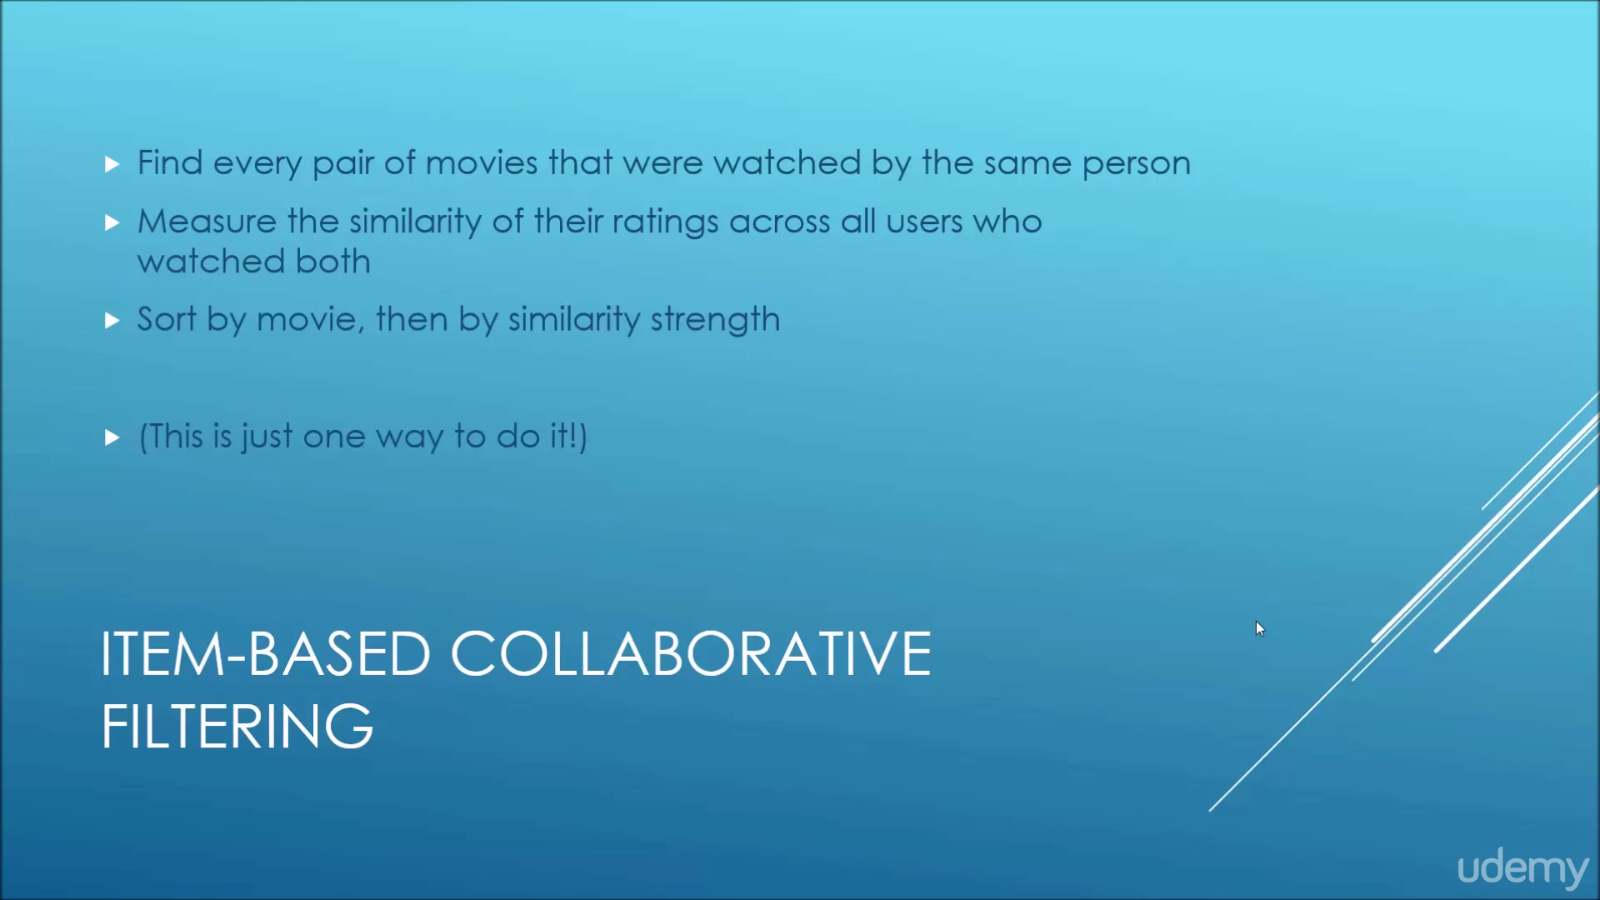

In [3]:
Image(filename='data/movie_rating.png')

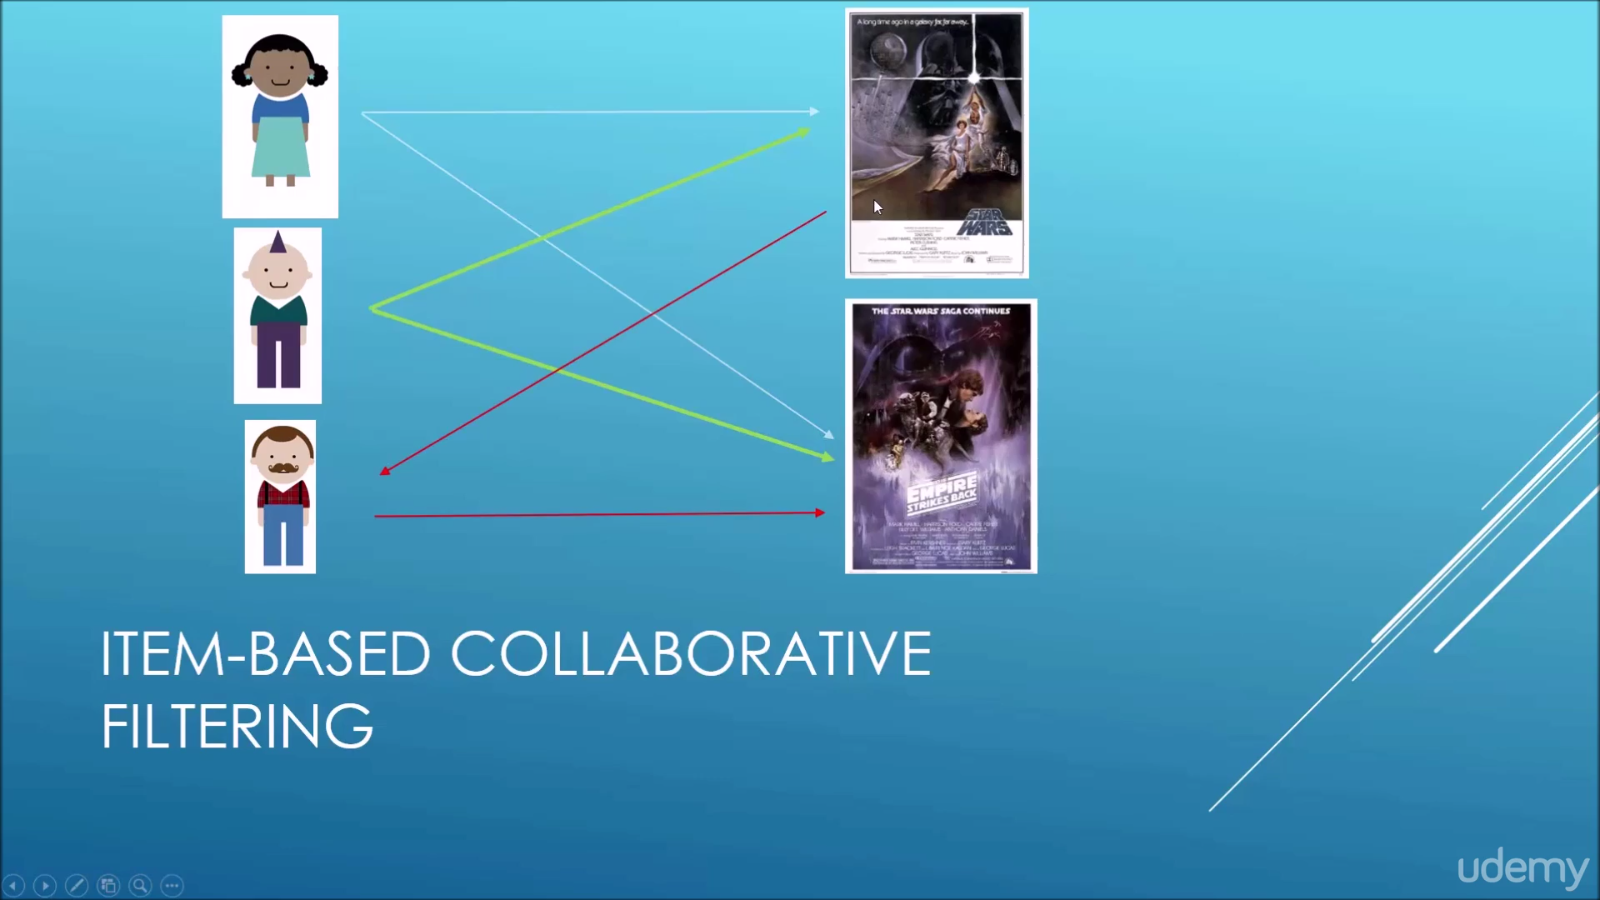

In [4]:
Image(filename='data/movie_illustr.png')

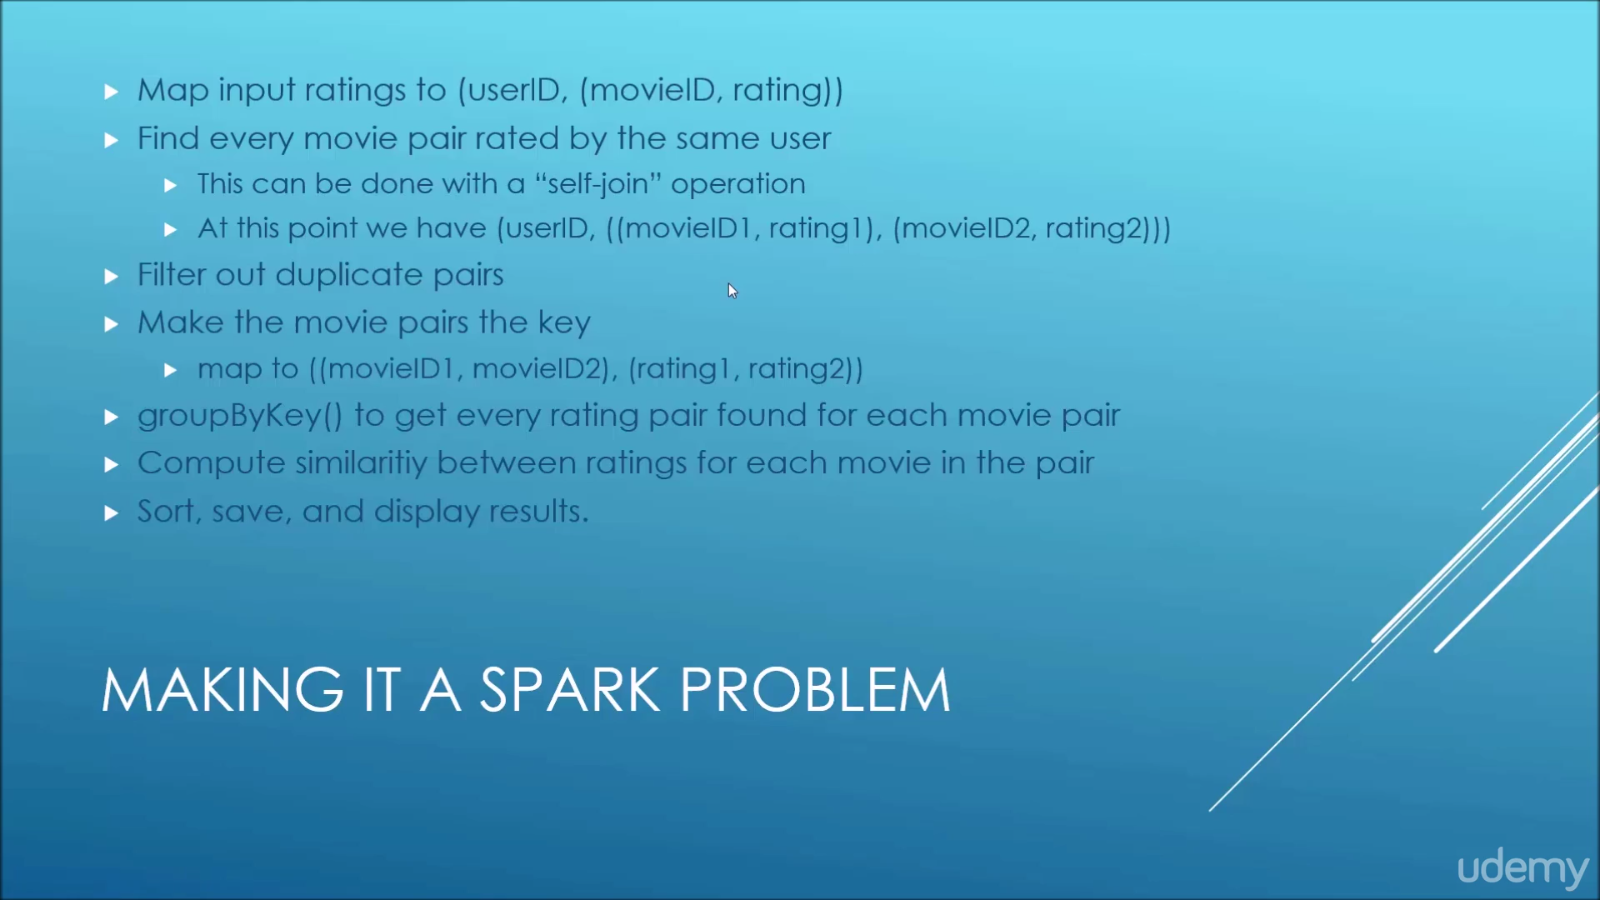

In [5]:
Image(filename='data/movie_steps.png')

##### Once computed, Spark ignores an RDD

##### If you perform some action on RDD more than once, we must ask Spark to cache or persist it

##### Persist gives the additional option of saving to a disk than memory in case of a node failure.

In [6]:
import sys
from pyspark import SparkConf, SparkContext
from math import sqrt

In [16]:
def loadMovieNames():
    movieNames = {}
    with open("data/ml-100k/u.item", encoding='ascii', errors='ignore') as f:
        for line in f:
            fields = line.split('|')
            movieNames[int(fields[0])] = fields[1]
    return movieNames


##### Python 3 doesn't let you pass around unpacked tuples, so we explicitly extract the ratings now.


In [8]:
def makePairs( userRatings ):
    ratings = userRatings[1]
    (movie1, rating1) = ratings[0]
    (movie2, rating2) = ratings[1]
    return ((movie1, movie2), (rating1, rating2))

def filterDuplicates( userRatings ):
    ratings = userRatings[1]
    (movie1, rating1) = ratings[0]
    (movie2, rating2) = ratings[1]
    return movie1 < movie2

def computeCosineSimilarity(ratingPairs):
    numPairs = 0
    sum_xx = sum_yy = sum_xy = 0
    for ratingX, ratingY in ratingPairs:
        sum_xx += ratingX * ratingX
        sum_yy += ratingY * ratingY
        sum_xy += ratingX * ratingY
        numPairs += 1

    numerator = sum_xy
    denominator = sqrt(sum_xx) * sqrt(sum_yy)

    score = 0
    if (denominator):
        score = (numerator / (float(denominator)))

    return (score, numPairs)


In [9]:
conf = SparkConf().setMaster("local[*]").setAppName("MovieSimilarities")
sc = SparkContext(conf = conf)


In [17]:
print("\nLoading movie names...")
nameDict = loadMovieNames()



Loading movie names...


In [18]:
data = sc.textFile("data/ml-100k/u.data")


##### Map ratings to key / value pairs: user ID => movie ID, rating


In [19]:
ratings = data.map(lambda l: l.split()).map(lambda l: (int(l[0]), (int(l[1]), float(l[2]))))


##### Emit every movie rated together by the same user.
##### Self-join to find every combination.


In [20]:
joinedRatings = ratings.join(ratings)


At this point our RDD consists of userID => ((movieID, rating), (movieID, rating))

Filter out duplicate pairs

##### Filter out duplicate pairs


In [22]:
uniqueJoinedRatings = joinedRatings.filter(filterDuplicates)


##### Now key by (movie1, movie2) pairs.


In [23]:
moviePairs = uniqueJoinedRatings.map(makePairs)


##### # We now have (movie1, movie2) => (rating1, rating2)

Now collect all ratings for each movie pair and compute similarity

In [25]:
moviePairRatings = moviePairs.groupByKey()



 We now have (movie1, movie2) = > (rating1, rating2), (rating1, rating2) ...

Can now compute similarities.

In [26]:
moviePairSimilarities = moviePairRatings.mapValues(computeCosineSimilarity).cache()


##### Save the results if desired
moviePairSimilarities.sortByKey()
moviePairSimilarities.saveAsTextFile("movie-sims")

##### Extract similarities for the movie we care about that are "good".


In [28]:
if (len(sys.argv) > 1):

    scoreThreshold = 0.97
    coOccurenceThreshold = 50

    movieID = int(sys.argv[1])

    # Filter for movies with this sim that are "good" as defined by
    # our quality thresholds above
    filteredResults = moviePairSimilarities.filter(lambda pairSim: \
        (pairSim[0][0] == movieID or pairSim[0][1] == movieID) \
        and pairSim[1][0] > scoreThreshold and pairSim[1][1] > coOccurenceThreshold)

    # Sort by quality score.
    results = filteredResults.map(lambda pairSim: (pairSim[1], pairSim[0])).sortByKey(ascending = False).take(10)

    print("Top 10 similar movies for " + nameDict[movieID])
    for result in results:
        (sim, pair) = result
        # Display the similarity result that isn't the movie we're looking at
        similarMovieID = pair[0]
        if (similarMovieID == movieID):
            similarMovieID = pair[1]
        print(nameDict[similarMovieID] + "\tscore: " + str(sim[0]) + "\tstrength: " + str(sim[1]))


ValueError: invalid literal for int() with base 10: '-f'